In [1]:
# import package
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


In [3]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)


Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
learning_rate = 0.001
training_epochs = 101
batch_size = 100
display_step = 5

In [5]:
n_hidden_1 = 500
n_hidden_2 = 500
n_z = 20
n_input = 784

In [7]:
transfer_func = tf.nn.softplus

In [8]:
# input
X = tf.placeholder(tf.float32, [None, n_input])

In [9]:
def xavier_init(fan_in, fan_out, constant=1):
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(6.0/(fan_in + fan_out))
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out),
                             minval=low, maxval=high,
                             dtype=tf.float32)

In [13]:
weights = {
    "recognition_h1": tf.Variable(xavier_init(n_input, n_hidden_1)),
    "recognition_h2": tf.Variable(xavier_init(n_hidden_1, n_hidden_2)),
    "recognition_out_mean": tf.Variable(xavier_init(n_hidden_2, n_z)),
    "recognition_out_log": tf.Variable(xavier_init(n_hidden_2, n_z)),
    "generator_h1": tf.Variable(xavier_init(n_z, n_hidden_1)),
    "generator_h2": tf.Variable(xavier_init(n_hidden_1, n_hidden_2)),
    "generator_out_mean": tf.Variable(xavier_init(n_hidden_2, n_input)),
    "generator_out_log": tf.Variable(xavier_init(n_hidden_2, n_input)),
}

biases = {
    "recognition_b1": tf.Variable(tf.zeros([n_hidden_1], dtype=tf.float32)),
    "recognition_b2": tf.Variable(tf.zeros([n_hidden_2], dtype=tf.float32)),
    "recognition_out_mean": tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
    "recognition_out_log": tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
    "generator_b1": tf.Variable(tf.zeros([n_hidden_1], dtype=tf.float32)),
    "generator_b2": tf.Variable(tf.zeros([n_hidden_2], dtype=tf.float32)),
    "generator_out_mean": tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
    "generator_out_log": tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
}

In [11]:
def recognition_network(x):
    layer_1 = transfer_func(tf.add(tf.matmul(x, weights["recognition_h1"]), biases["recognition_b1"]))
    layer_2 = transfer_func(tf.add(tf.matmul(layer_1, weights["recognition_h2"]), biases["recognition_b2"]))

    z_mean = tf.add(tf.matmul(layer_2, weights["recognition_out_mean"]), biases["recognition_out_mean"])
    z_log = tf.add(tf.matmul(layer_2, weights["recognition_out_log"]), biases["recognition_out_log"])

    return z_mean, z_log

def generator_network(x):
    layer_1 = transfer_func(tf.add(tf.matmul(x, weights["generator_h1"]), biases["generator_b1"]))
    layer_2 = transfer_func(tf.add(tf.matmul(layer_1, weights["generator_h2"]), biases["generator_b2"]))

    x_reconstr_mean = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights["generator_out_mean"]), biases["generator_out_mean"]))

    return x_reconstr_mean

In [14]:
z_mean, z_log = recognition_network(X)

eps = tf.random_normal((batch_size, n_z), 0, 1, dtype=tf.float32)

# z = mu + sigma*epsilon
z = tf.add(z_mean, tf.multiply(tf.sqrt(tf.exp(z_log)), eps))

x_reconstr_mean = generator_network(z)

In [15]:
# 重建损失：负对数概率，伯努利分布下的输入
reconstr_loss = -tf.reduce_sum(X * tf.log(1e-10 + x_reconstr_mean) + (1 - X) * tf.log(1e-10 + 1 - x_reconstr_mean), 1)

# 潜在损失
latent_loss = -0.5 * tf.reduce_sum(1 + z_log - tf.square(z_mean) - tf.exp(z_log), 1)

cost = tf.reduce_mean(reconstr_loss + latent_loss)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [16]:
def generate(session, z_mu=None):
    """ Generate data by sampling from latent space.

    If z_mu is not None, data for this point in latent space is
    generated. Otherwise, z_mu is drawn from prior in latent 
    space.        
    """
    if z_mu is None:
        z_mu = np.random.normal(size=n_z)
    # Note: This maps to mean of distribution, we could alternatively
    # sample from Gaussian distribution
    return session.run(x_reconstr_mean, feed_dict={z: z_mu})

Epoch: 0001 cost= 133.717727661
Epoch: 0006 cost= 108.476936340
Epoch: 0011 cost= 104.602188110
Epoch: 0016 cost= 102.165885925
Epoch: 0021 cost= 102.320602417
Epoch: 0026 cost= 99.762496948
Epoch: 0031 cost= 97.980880737
Epoch: 0036 cost= 104.637420654
Epoch: 0041 cost= 100.169929504
Epoch: 0046 cost= 94.087226868
Epoch: 0051 cost= 97.151901245
Epoch: 0056 cost= 93.907005310
Epoch: 0061 cost= 94.757575989
Epoch: 0066 cost= 94.783302307
Epoch: 0071 cost= 91.889137268
Epoch: 0076 cost= 96.507812500
Epoch: 0081 cost= 94.086746216
Epoch: 0086 cost= 96.656387329
Epoch: 0091 cost= 94.274803162
Epoch: 0096 cost= 94.293968201
Epoch: 0101 cost= 103.519912720
Optimization Finished!


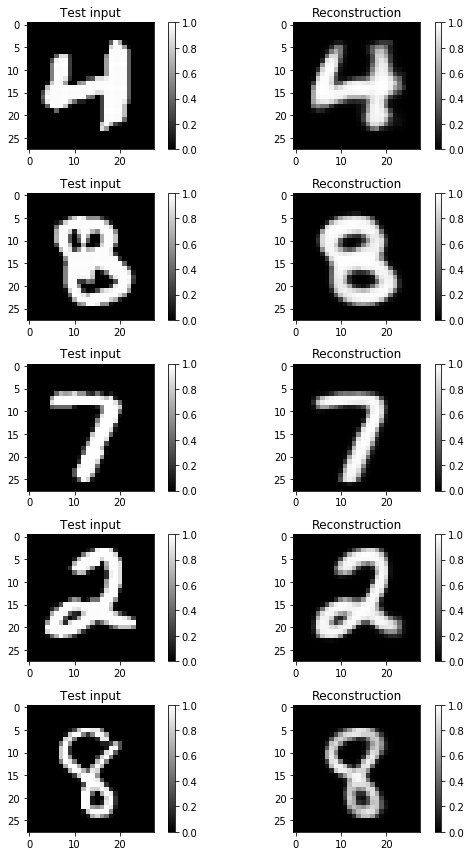

In [17]:

# Initializing the variables# Initia 
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    total_batch = int(mnist.train.num_examples / batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
            avg_cost += c / mnist.train.num_examples * batch_size
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch + 1),
                  "cost=", "{:.9f}".format(c))

    print("Optimization Finished!")
        
        
    # generator
    x_sample = mnist.test.next_batch(100)[0]
    x_reconstruct = sess.run(x_reconstr_mean, feed_dict={X: x_sample})

    plt.figure(figsize=(8, 12))
    for i in range(5):
        plt.subplot(5, 2, 2 * i + 1)
        plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
        plt.title("Test input")
        plt.colorbar()
        plt.subplot(5, 2, 2 * i + 2)
        plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, cmap="gray")
        plt.title("Reconstruction")
        plt.colorbar()
    plt.tight_layout()
